# A Cognitive Model or Harmonic Types (Simplified Amortization)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis/probabilistic_harmony_model

Mounted at /content/drive
/content/drive/MyDrive/Thesis/probabilistic_harmony_model


In [2]:
!pip install pyro-api==0.1.2
!pip install pyro-ppl==1.8.4
!pip install pitchtypes==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 13.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [3]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from pyro.distributions import *
#from collections import Counter
import pyro.infer
import pyro.optim
import pyro.util
pyro.enable_validation(True)

import matplotlib.pyplot as plt
import tqdm

import numpy as np
import pandas as pd
import scipy.stats as stats

import os.path as path
from datetime import datetime
import json

import utils

import gc

In [4]:
gpu = torch.cuda.is_available()
gpu_n = 0
torch.set_default_dtype(torch.float64)
device = torch.device(f'cuda:{gpu_n}' if gpu else 'cpu')
torch.set_default_device(device)
print(device)

cuda:0


In [5]:
def save_rng_state(name):
    fn = name + '-' + datetime.today().isoformat() + '.state'
    state = pyro.util.get_rng_state()
    with open('rng-' + fn, 'w') as f:
        print(state, file=f)
    torch.save(state['torch'], 'torch-' + fn)

In [6]:
# set random seeds
pyro.set_rng_seed(0)
#torch.set_deterministic(True)
#torch.set_num_threads(1)
#torch.set_num_interop_threads(1)

# fix the range of pitches we consider
fifth_range = 2*7                  # 2 diatonics
npcs = 2*fifth_range+1             # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range) # used to make helper functions work correctly

# **1. Amortization**



## Step 1: Model

**Notations:**
- $h$: probablity distribution of chords (harmony)
- $\Phi$: chord profile for all chord types, where each $\phi_i$ conntains weights for each chord
- $npcs$: range of line of fifths, which is the number of pitches we consider
- $n_{harmonies}$: number of different chord types
- $n_{chords}$: length of dataset (how many chords we observe in the dataset)

**Generating Process:**

For all $i$:

- $\phi_i \sim Dirichlet(0.5, npcs)$
- $h \sim Dirichlet(0.5, n_{harmonies})$

    For each chord j:
    - Choose chords: $c_i \sim Categorical(h)$
    - Choose pitches: $p_j \sim Multinomial(\phi_{cj}, N_j)$

where $p_j$ and $N_j$ are observed, other variables are unobserved.

In [7]:
def simplified_chord_model(nharmonies, nchords, data):
  # parameters priors:
  # distribution of the harmonies
  p_harmony = pyro.sample('p_harmony', dist.Dirichlet(torch.ones(nharmonies, device=device)))

  # distribution of notes in the harmonies (chord profiles)
  with pyro.plate("harmonies", nharmonies):
    chord_profiles = pyro.sample("theta", dist.Dirichlet(torch.ones(npcs, device=device)))

  # Sampling the data:
  nchords = len(data['c'])
  with pyro.plate("chords", nchords) as ind:
    # sample a chord type based on the harmony distribution (to be inferred)
    # c = pyro.sample('c', dist.Categorical(p_harmony))
    # sample chord types from a uniform categorical distribution
    c = pyro.sample("c", dist.Categorical(torch.ones(nharmonies, device=device) / nharmonies))

    # sampling pitches for the chord based on the selected chord type profile
    pyro.sample("notes", dist.Multinomial(1, chord_profiles[c], validate_args=False), obs=data['pitches'][ind])

### **Truncated Dirichlet Process**

**Choosing $N_{max}$**: $N_{max}$ is the potential maximum number of chord types and should be chosen based on the size and diversity of the dataset. Selecting too large a value may lead to wastage of computational resources, while too small a value could limit the flexibility of the model.

**Adjusting $α$**: The concentration parameter $α$ of the Dirichlet Process affects how many different chord types the model prefers. A larger $α$ tends to generate more chord types, while a smaller $α$ results in fewer types.

In [8]:
def truncated_dirichlet_process(alpha, N_max):
    # sample beta parameters for the stick-breaking process
    betas = pyro.sample('betas', dist.Beta(1, alpha).expand([N_max]))
    pi = torch.zeros(N_max)
    # first stick fraction directly becomes the first weight
    pi[0] = betas[0]

    # sequentially break the stick and assign weights for the rest of the components
    for i in range(1, N_max):
        # the weight for the i-th component is the i-th beta times the product of (1 - beta) for all previous betas
        pi[i] = betas[i] * torch.prod(1.0 - betas[:i])
    return pi

def tdp_model(data, alpha, N_max, npcs):
    # Truncated Dirichlet Process for harmony weights
    pi = truncated_dirichlet_process(alpha, N_max)

    with pyro.plate("harmonies", N_max):
        chord_profiles = pyro.sample("theta", dist.Dirichlet(torch.ones(npcs)))

    nchords = len(data['c'])
    with pyro.plate("chords", nchords) as ind:
        c = pyro.sample("c", dist.Categorical(pi))

        # sampling pitches for the chord based on the selected chord type profile
        pyro.sample("notes", dist.Multinomial(1, chord_profiles[c], validate_args=False), obs=data['pitches'][ind])

## Step 2: Amortization Guide for Inference


In [9]:
def normalize_notes(notes):
  scale = 1/torch.max(notes, dim=1).values
  return torch.mul(notes, scale.reshape(len(scale), 1))

In [10]:
class AmortizedChordGuide(nn.Module):
  # def __init__(self, nharmonies):
  #       super().__init__()
  #       hidden = 32
  #       self.f = nn.Sequential(
  #           nn.Linear(npcs, hidden),
  #           nn.ReLU(),
  #           nn.Linear(hidden, nharmonies),
  #           nn.Softmax(dim=-1)
  #       )

  # def forward(self, x):
  #       return self.f(normalize_notes(x))

  def __init__(self, nharmonies):
      super().__init__()
      hidden = 32
      self.f = nn.Sequential(
          nn.Linear(npcs, hidden),
          nn.SELU(),
          nn.Dropout(0.2),
          nn.Linear(hidden, nharmonies),
          nn.Softmax(dim=1)
      )

  def forward(self, notes):
      return self.f(normalize_notes(notes))

  def guide(self, nharmonies, nchords, data):
      pyro.module("chord_predictor", self)

      # for harmony distribution
      alpha_h = pyro.param('alpha_h', torch.ones(nharmonies, device=device), constraint=constraints.positive)
      pyro.sample('p_harmony', dist.Dirichlet(alpha_h))

      # for chord profiles
      alpha_phi = pyro.param("alpha_phi", torch.ones(nharmonies, npcs, device=device), constraint=constraints.positive)
      with pyro.plate("harmonies", nharmonies):
        pyro.sample("theta", dist.Dirichlet(alpha_phi))

      # for chords
      nchords = len(data['c'])
      subs = min(500, nchords)
      with pyro.plate("chords", nchords, subsample_size=subs) as ind:
        chord_type_params = self.forward(data['pitches'][ind])
        pyro.sample("c", dist.Categorical(chord_type_params))

      return alpha_phi, alpha_h

In [11]:
class TDPGuide(nn.Module):
    def __init__(self, max_nharmonies, npcs, device):
        super().__init__()
        self.max_nharmonies = max_nharmonies
        self.npcs = npcs
        self.device = device

        hidden = 32
        self.f = nn.Sequential(
            nn.Linear(npcs, hidden),
            nn.SELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden, max_nharmonies),
            nn.Softmax(dim=1)
        )

    def guide(self, alpha, N_max, npcs, nchords, data, device):
        pyro.module("tdp_chord_predictor", self)


## Step 3: Data and Conditioning
**Data Format**


In [12]:
def simplified_chord_tensor(notes):
    """Takes a list of fifths and returns a vector of counts for fifths."""
    chord = torch.zeros(npcs, device=device)
    for fifth in notes:
        index = utils.fifth_to_index(fifth)
        chord[index] += 1
    return chord

def simplified_annot_data_obs(chords):
    """Helper function to turn a list of chord dictionaries into a dictionary of observation vectors."""
    obs = {}
    obs["pitches"] = torch.cat([simplified_chord_tensor(c['notes']).reshape((1, -1)) for c in chords], dim=0)
    obs["c"] = torch.tensor([c['label'] for c in chords], device=device)
    obs["n"] = torch.tensor([len(c['notes']) - 1 for c in chords], device=device)
    return obs

**Loading the Dataset**

The data is loaded from a TSV file that. The resulting dataframe is converted to the observation format that we pass to the model.

In [20]:
def load_dataset(filename):
    filename = path.join("data", filename)
    print("loading dataset...")
    df = utils.load_csv(filename)
    sizes = df.groupby(['chordid', 'label']).size()
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    chordtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(chordtypes.index)

    # check if precomputed tensor data is available:
    prefn = filename + "_simplified.pt"
    if path.exists(prefn) and path.getmtime(prefn) > path.getmtime(filename):
        print("using precomputed tensor data.")
        obs = torch.load(prefn, map_location=device)
    else:
        print('extracting chords...')
        chords = [{'label': numlabel, 'notes': [row['fifth'] for index, row in grp.iterrows()]}
                  for (_, numlabel), grp in tqdm.tqdm(df.groupby(['chordid', 'numlabel']))]
        print('converting chords to tensors...')
        obs = simplified_annot_data_obs(chords)
        torch.save(obs, prefn)

    print(len(chordtypes), "chord types")
    print(len(obs["c"]), "chords")
    return df, obs, chordtypes

After inferring the parameters we save them for easier inspection and reuse.



In [21]:
def save_params(params, nharmonies, npcs, name):
    # Save the PyTorch parameters
    torch.save(params , path.join("results", name + '.pt'))

    # Save the parameters in a JSON file for easy access
    with open(path.join("results", name + '.json'), 'w') as f:
        json.dump({'params': {key: val.tolist() for key, val in params.items()},
                   'nharmonies': nharmonies,
                   'npcs': npcs},
                  f)

## Step 4: Inference

**Initial Training with Uniform Prior:**

In the `simplified_chord_model`, chord types (`c`) are initially sampled from a uniform distribution: `dist.Categorical(torch.ones(nharmonies, device=device) / nharmonies)`. This setup ensures that the initial training phase does not assume any prior knowledge about the prevalence of different chord types.

**Transition to Learning Chord Prevalence:**

The function `infer_with_p_harmony` updates the model to incorporate learning the prevalence of chord types (`p_harmony`). In this updated model, chord types are sampled based on `p_harmony`: `dist.Categorical(p_harmony)`, which is learned from the data. This shift refines the model based on observed distributions after the initial exploration phase.

In [22]:
def infer_amortized_posteriors(npcs, nharmonies, data, nsteps=5000, lr=0.005, step_size=100, plot_loss=True, save_as=None, collect_history=False):
    pyro.clear_param_store()
    pyro.set_rng_seed(1625)

    # create an instance of the guide
    amortized_guide = AmortizedChordGuide(nharmonies).to(device)

    svi = pyro.infer.SVI(model=simplified_chord_model,
                         guide=amortized_guide.guide,
                         optim=pyro.optim.Adam({"lr": lr, "foreach": False}),
                         loss=pyro.infer.Trace_ELBO())

    losses = []
    alpha_phi_history = []

    for i in tqdm.tqdm(range(nsteps)):
        loss = svi.step(nharmonies, len(data['c']), data)
        losses.append(loss)

        if collect_history:
            # collect parameter histories
            alpha_phi_history.append(pyro.param('alpha_phi').detach().cpu().numpy())

        # if step % 100 == 0:
        #     print(f"Step {step} : loss = {loss}")

    # plot the loss
    if plot_loss:
        plt.figure(figsize=(12, 5))
        plt.plot(losses)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title(f"SVI Convergence ({save_as})")
        plt.show()

    # save inferred parameters
    params = {name: value.detach().cpu().numpy() for name, value in pyro.get_param_store().items()}

    if save_as is not None:
        save_params(params, nharmonies, npcs, save_as)

    return params, amortized_guide, alpha_phi_history if collect_history else params

In [23]:
def infer_with_p_harmony(nharmonies, npcs, data, trained_network, nsteps=5000, lr=0.005):
    def updated_model(nharmonies, nchords, data):
        p_harmony = pyro.sample('p_harmony', dist.Dirichlet(torch.ones(nharmonies, device=device)))

        with pyro.plate("harmonies", nharmonies):
            chord_profiles = pyro.sample("theta", dist.Dirichlet(torch.ones(npcs, device=device)))

        nchords = len(data['c'])
        with pyro.plate("chords", nchords) as ind:
            c = pyro.sample("c", dist.Categorical(p_harmony))
            pyro.sample("notes", dist.Multinomial(1, chord_profiles[c], validate_args=False), obs=data['pitches'][ind])

    pyro.clear_param_store()
    amortized_guide = trained_network

    svi = SVI(model=updated_model,
              guide=amortized_guide.guide,
              optim=Adam({"lr": lr}),
              loss=Trace_ELBO())

    losses = []
    for step in tqdm.tqdm(range(nsteps)):
        loss = svi.step(nharmonies, len(data['c']), data)
        losses.append(loss)

    # plot the loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.show()

    return {name: pyro.param(name).detach().cpu().numpy() for name in pyro.get_param_store().keys()}

## Step 5: Plotting

In [24]:
def plot_param_histories(alpha_phi_history):
    alpha_phi_mean_history = np.mean(alpha_phi_history, axis=-1)  # Compute the mean over pitch classes
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_phi_mean_history)
    plt.title('Mean Alpha_phi parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Alpha_phi values')
    plt.show()

In [25]:
def plot_harmony_distribution(params, nharmonies, save_as=None):
    harmony_params = params['alpha_h']

    # create a bar chart for the harmony distribution
    plt.figure(figsize=(8, 4))
    plt.bar(np.arange(nharmonies), harmony_params)
    plt.title('Harmony Distribution')
    plt.xlabel('Chord Type Index')
    plt.ylabel('Probability')
    plt.xticks(np.arange(nharmonies))

    plt.tight_layout()
    if save_as:
        plt.savefig(f"{save_as}.png")
    plt.show()

In [26]:
def plot_chord_profiles(params, nharmonies, npcs, save_as=None):
    chord_profile_params = params['alpha_phi']

    fig, axs = plt.subplots(nharmonies, 1, figsize=(12, 3 * nharmonies), squeeze=False)

    # plot chord profile parameters for each harmony
    for i in range(nharmonies):
        # Normalize chord profile parameters for plotting
        # chord_profile_normalized = chord_profile_params[i] / np.sum(chord_profile_params[i])
        axs[i, 0].bar(np.arange(npcs), chord_profile_params[i])
        axs[i, 0].set_title(f'Chord Profile for Harmony {i}')
        axs[i, 0].set_xlabel('Pitch Index')
        axs[i, 0].set_ylabel('Probability')

    plt.tight_layout()
    if save_as:
        plt.savefig(f"{save_as}.png")
    plt.show()

# **2. Experiment**

In [27]:
dcml_df, dcml_obs, dcml_chordtypes = load_dataset('dcml.tsv')

loading dataset...
extracting chords...


100%|██████████| 113771/113771 [00:55<00:00, 2045.60it/s]


converting chords to tensors...
14 chord types
113771 chords


100%|██████████| 5000/5000 [01:33<00:00, 53.59it/s]


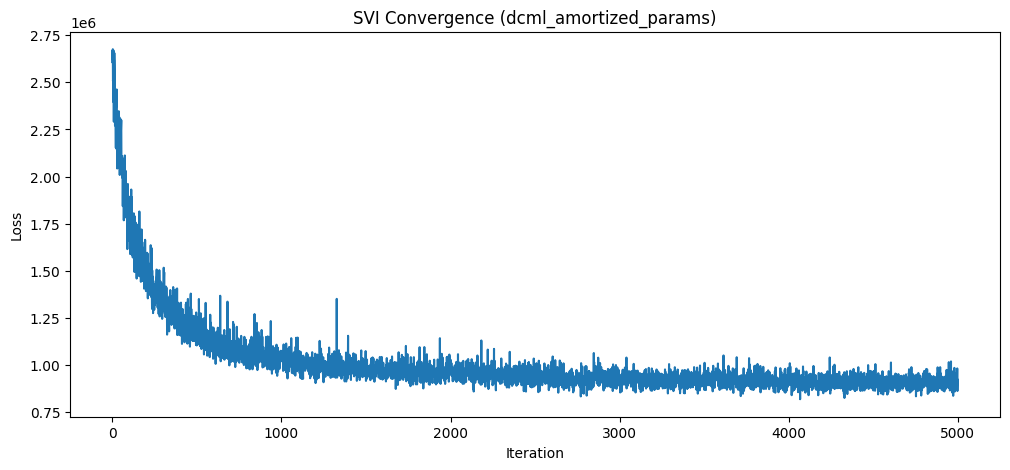

In [34]:
dcml_params, amortized_guide, alpha_phi_history = infer_amortized_posteriors(npcs, len(dcml_chordtypes), dcml_obs,
                                                                              nsteps=5000, lr=0.01, plot_loss=True,
                                                                              save_as="dcml_amortized_params", collect_history=True
                                                                              )

100%|██████████| 5000/5000 [01:36<00:00, 52.05it/s]


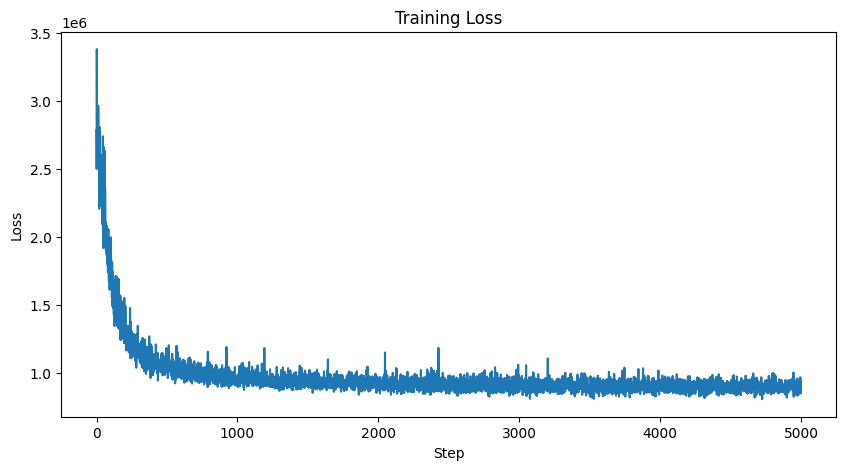

In [35]:
dcml_params_stage2 = infer_with_p_harmony(len(dcml_chordtypes), npcs, dcml_obs, amortized_guide, nsteps=5000, lr=0.01)

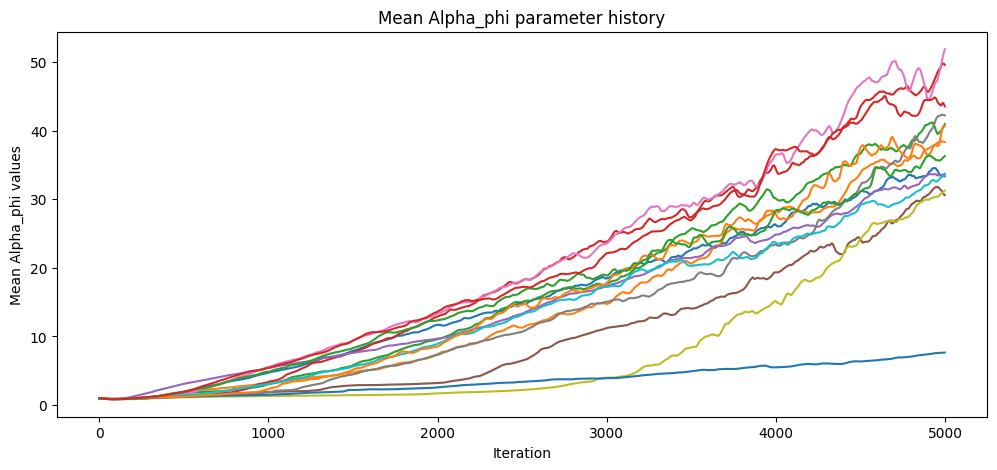

In [36]:
# Plot the parameter histories
plot_param_histories(alpha_phi_history)

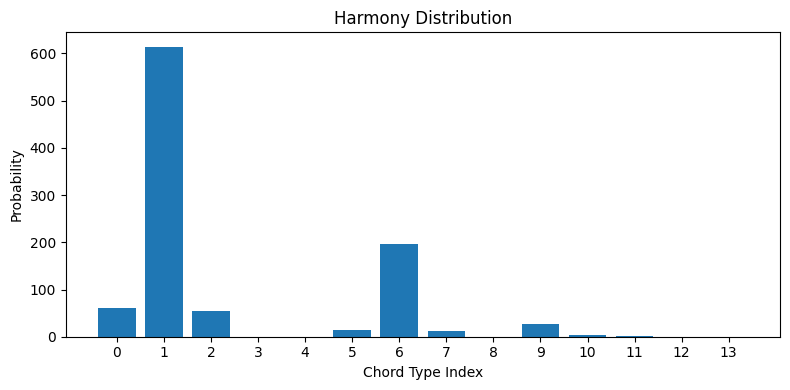

In [37]:
# plot_harmony_distribution(dcml_params, len(dcml_chordtypes), save_as="dcml_harmony_distribution")
plot_harmony_distribution(dcml_params_stage2, len(dcml_chordtypes), save_as="dcml_harmony_distribution")

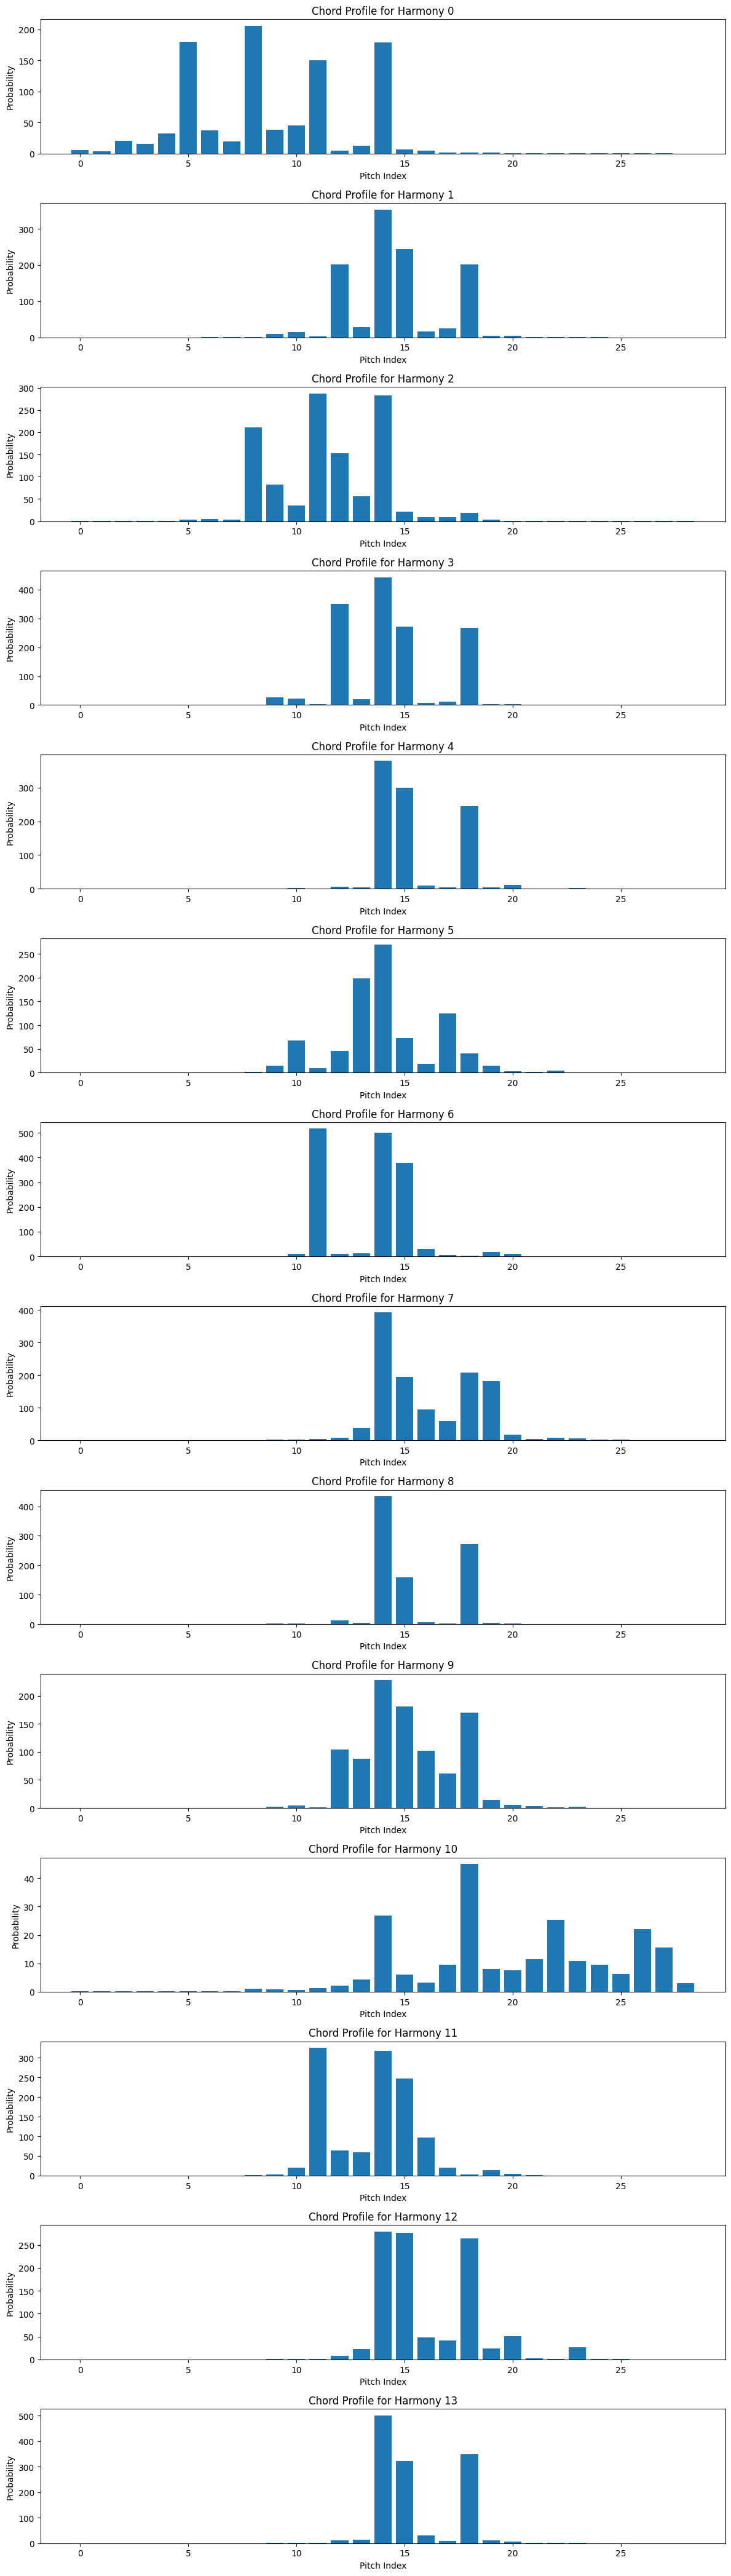

In [38]:
plot_chord_profiles(dcml_params, len(dcml_chordtypes), npcs, save_as="dcml_chord_profiles")

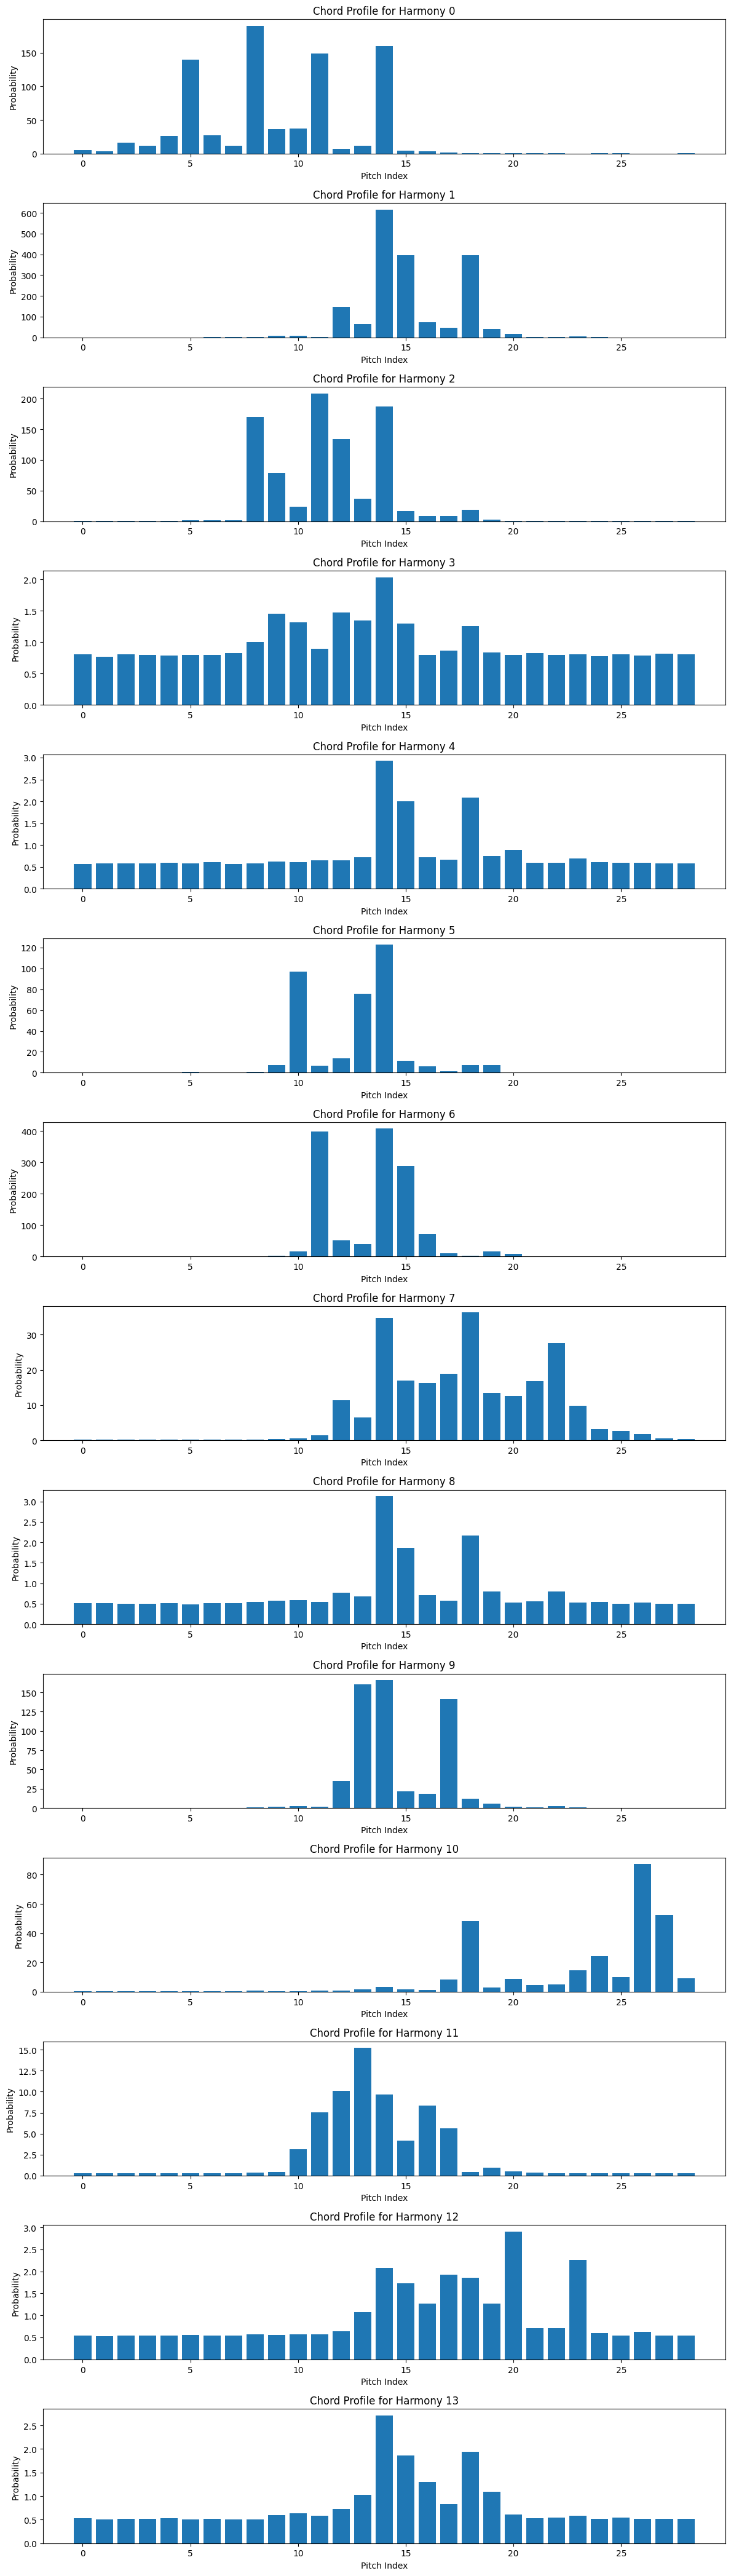

In [39]:
plot_chord_profiles(dcml_params_stage2, len(dcml_chordtypes), npcs, save_as="dcml_chord_profiles")